In [1]:
# example of training a stable gan for generating a handwritten digit
from os import makedirs
from numpy import expand_dims, zeros, ones, vstack
from numpy.random import randn, randint
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from tensorflow.keras.initializers import RandomNormal
from matplotlib import pyplot

In [2]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # define model
    model = Sequential()
    # downsample to 14x14
    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init,
                     input_shape=in_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 7x7
    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [3]:
# define the standalone generator model
def define_generator(latent_dim):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # define model
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128*7*7
    model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7,7,128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # output 28x28x1
    model.add(Conv2D(1, (7,7), activation='tanh', padding='same', kernel_initializer=init))
    return model

In [4]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [5]:
# load mnist images
def load_real_samples():
    # load dataset
    (trainX, trainy),(_,_) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # select all of the examples for a given class
    selected_ix = trainy == 8
    X = X[selected_ix]
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X-127.5)/127.5
    return X

In [6]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # select images
    X = dataset[ix]
    # generate class labels
    y = ones((n_samples,1))
    return X,y

In [7]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim*n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

In [8]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n_samples, 1))
    return X,y

In [9]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X+1)/2.0
    # plot images
    pyplot.figure(figsize=(20,20))
    for i in range(10*10):
        # define subplot
        pyplot.subplot(10,10,1+i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i,:,:,0], cmap='gray_r')
    # save plot to file
    pyplot.savefig('results_baseline/generated_plot_%03d.png' % (step+1))
    pyplot.show()
    pyplot.close()
    # save the generator model
    g_model.save('results_baseline/model_%03d.h5' % (step+1))

In [10]:
# create a line plot of loss for the gan and save to file
def plot_history(d_hist, g_hist, a_hist):
    # plot loss
    pyplot.subplot(2,1,1)
    pyplot.plot(d1_hist, label='dis')
    pyplot.plot(g_hist, label='gen')
    pyplot.legend()
    # plot discriminator accuracy
    pyplot.subplot(2,1,2)
    pyplot.plot(a_hist, label='acc')
    pyplot.legend()
    # save plot to file
    pyplot.savefig('results_baseline/plot_line_plot_loss.png')
    pyplot.show()
    pyplot.close()

In [13]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=128):
    # calculate the number of batches per epoch
    bat_per_epo = int(dataset.shape[0]/n_batch)
    # calculate the total iterations based on batch and epoch
    n_steps = bat_per_epo * n_epochs
    # calculate the number of samples in half a batch
    half_batch = int(n_batch/2)
    # prepare lists for storing stats each iteration
    d_hist, g_hist, a_hist = list(), list(), list()
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        
        X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
        # update discriminator model weights
        d_loss, d_acc = d_model.train_on_batch(X, y)
        # prepare points in latent space as inputs for the generator
        X_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch,1))
        # update the generator via the discriminator's error
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
        # summarize loss on this batch
        print('>%d, d=%.3f, g=%.3f, a=%d' % 
              (i+1, d_loss, g_loss, int(100*d_acc)))
        # record history
        d_hist.append(d_loss)
        g_hist.append(g_loss)
        a_hist.append(d_acc)
        # evaluate the model performance every 'epoch'
        if (i+1)% bat_per_epo == 0:
            summarize_performance(i, g_model, latent_dim)
    plot_history(d_hist, g_hist, a_hist)

(5851, 28, 28, 1)
>1, d=0.881, g=0.700, a=30
>2, d=0.497, g=0.680, a=47
>3, d=0.282, g=0.660, a=100
>4, d=0.172, g=0.643, a=100
>5, d=0.124, g=0.627, a=100
>6, d=0.076, g=0.608, a=100
>7, d=0.059, g=0.594, a=100
>8, d=0.048, g=0.586, a=100
>9, d=0.034, g=0.581, a=100
>10, d=0.031, g=0.579, a=100
>11, d=0.027, g=0.575, a=100
>12, d=0.021, g=0.571, a=100
>13, d=0.021, g=0.568, a=100
>14, d=0.017, g=0.565, a=100
>15, d=0.015, g=0.561, a=100
>16, d=0.014, g=0.557, a=100
>17, d=0.015, g=0.553, a=100
>18, d=0.013, g=0.549, a=100
>19, d=0.013, g=0.545, a=100
>20, d=0.013, g=0.541, a=100
>21, d=0.012, g=0.538, a=100
>22, d=0.013, g=0.533, a=100
>23, d=0.011, g=0.531, a=100
>24, d=0.011, g=0.527, a=100
>25, d=0.011, g=0.527, a=100
>26, d=0.010, g=0.525, a=100
>27, d=0.011, g=0.525, a=100
>28, d=0.009, g=0.522, a=100
>29, d=0.009, g=0.518, a=100
>30, d=0.008, g=0.515, a=100
>31, d=0.007, g=0.513, a=100
>32, d=0.006, g=0.514, a=100
>33, d=0.007, g=0.513, a=100
>34, d=0.007, g=0.510, a=100
>35, d=

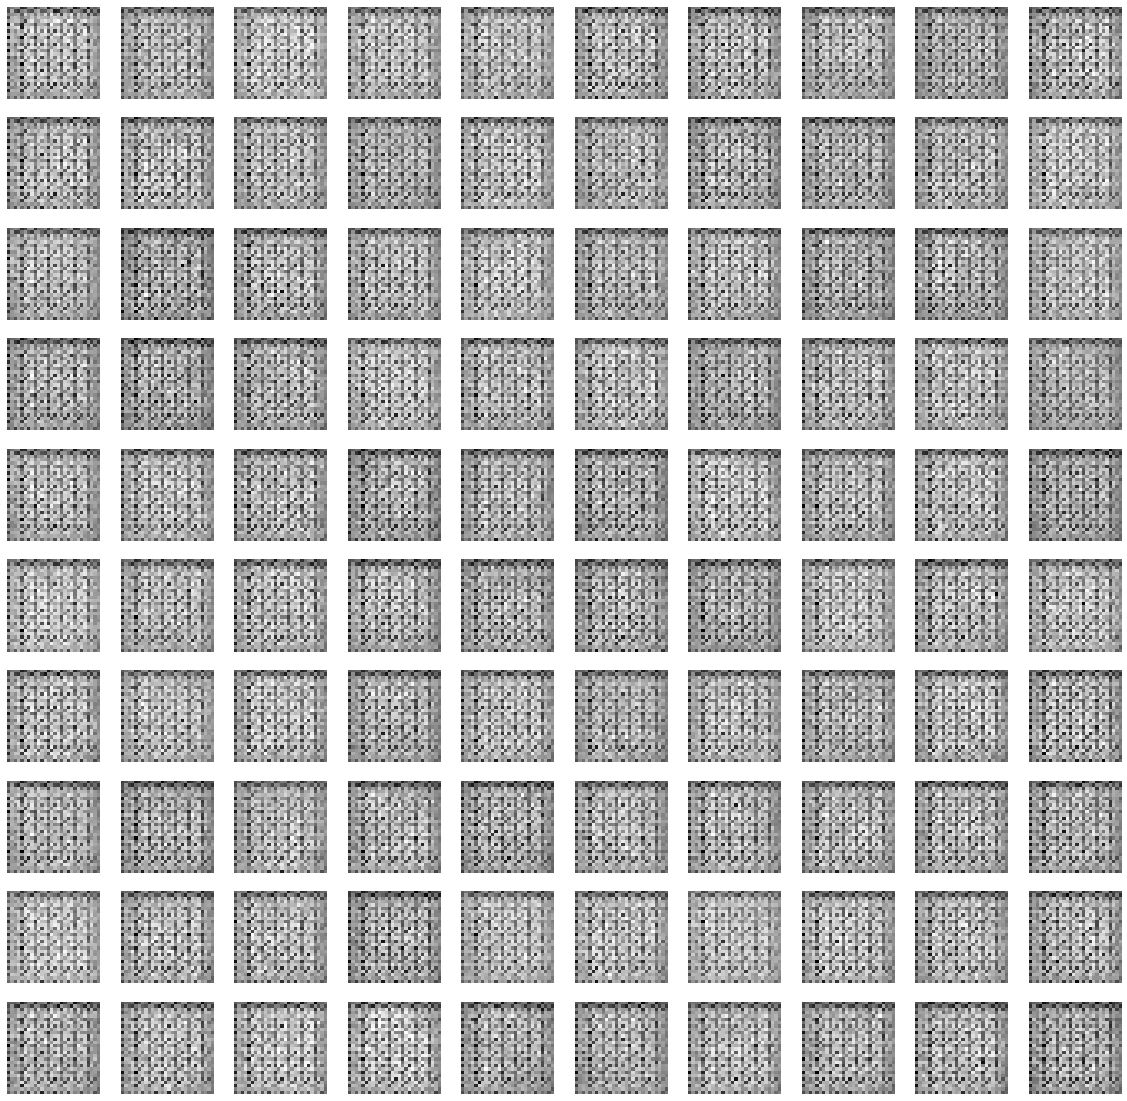

>46, d=0.004, g=0.493, a=100
>47, d=0.004, g=0.491, a=100
>48, d=0.004, g=0.491, a=100
>49, d=0.003, g=0.491, a=100
>50, d=0.004, g=0.491, a=100
>51, d=0.004, g=0.491, a=100
>52, d=0.004, g=0.492, a=100
>53, d=0.004, g=0.492, a=100
>54, d=0.003, g=0.487, a=100
>55, d=0.003, g=0.485, a=100
>56, d=0.003, g=0.484, a=100
>57, d=0.003, g=0.483, a=100
>58, d=0.003, g=0.483, a=100
>59, d=0.003, g=0.483, a=100
>60, d=0.004, g=0.481, a=100
>61, d=0.003, g=0.482, a=100
>62, d=0.003, g=0.481, a=100
>63, d=0.003, g=0.480, a=100
>64, d=0.002, g=0.480, a=100
>65, d=0.003, g=0.479, a=100
>66, d=0.003, g=0.478, a=100
>67, d=0.003, g=0.479, a=100
>68, d=0.002, g=0.478, a=100
>69, d=0.002, g=0.477, a=100
>70, d=0.003, g=0.476, a=100
>71, d=0.002, g=0.476, a=100
>72, d=0.003, g=0.475, a=100
>73, d=0.003, g=0.474, a=100
>74, d=0.002, g=0.473, a=100
>75, d=0.002, g=0.473, a=100
>76, d=0.003, g=0.471, a=100
>77, d=0.002, g=0.472, a=100
>78, d=0.002, g=0.472, a=100
>79, d=0.003, g=0.471, a=100
>80, d=0.002, 

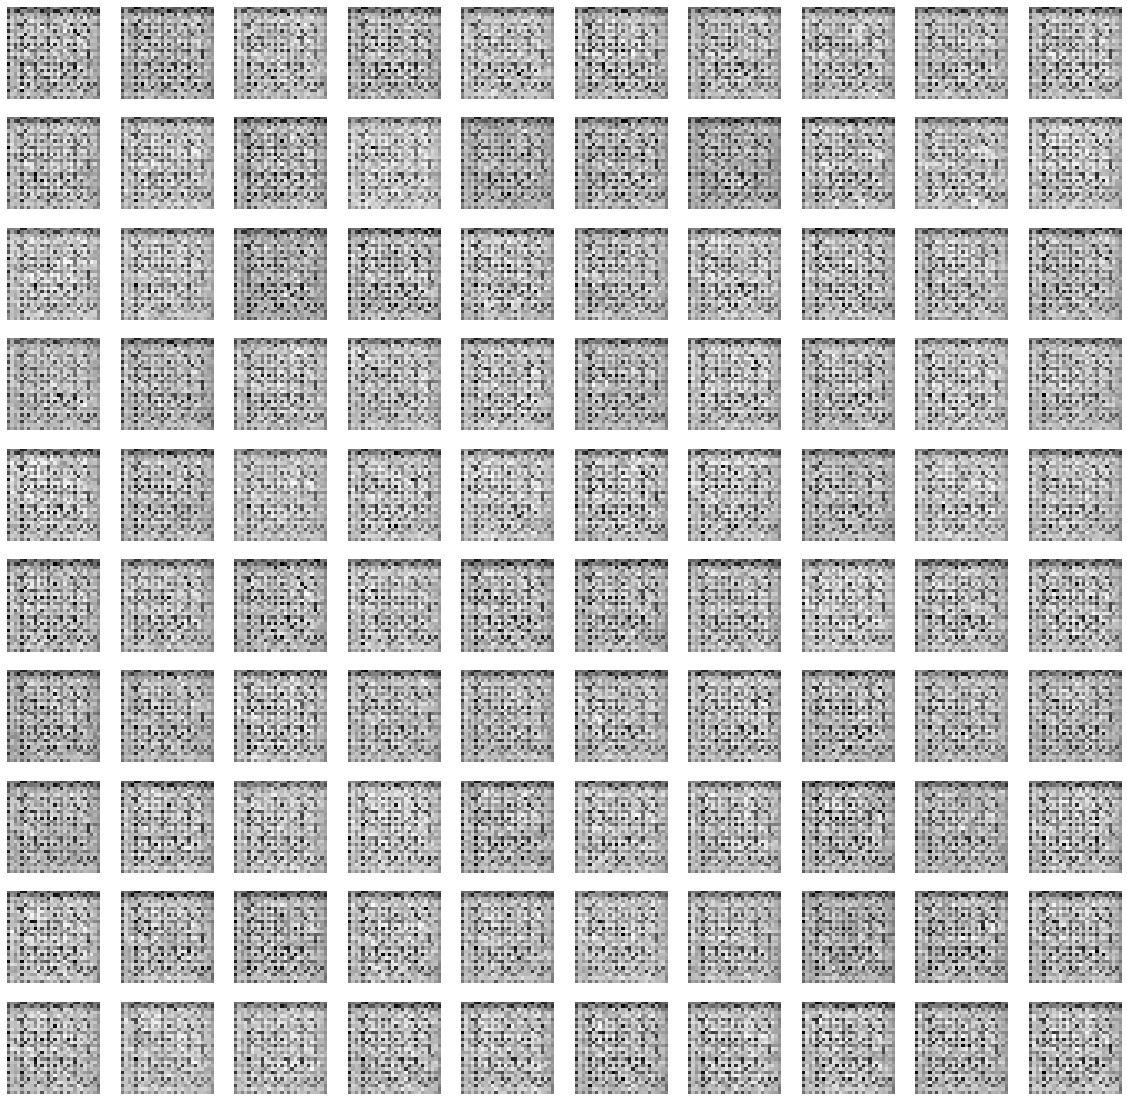

>91, d=0.002, g=0.469, a=100
>92, d=0.002, g=0.469, a=100
>93, d=0.002, g=0.470, a=100
>94, d=0.002, g=0.470, a=100
>95, d=0.003, g=0.469, a=100
>96, d=0.002, g=0.470, a=100
>97, d=0.002, g=0.470, a=100
>98, d=0.002, g=0.470, a=100
>99, d=0.002, g=0.471, a=100
>100, d=0.002, g=0.471, a=100
>101, d=0.002, g=0.472, a=100
>102, d=0.002, g=0.472, a=100
>103, d=0.002, g=0.472, a=100
>104, d=0.002, g=0.473, a=100
>105, d=0.002, g=0.475, a=100
>106, d=0.002, g=0.475, a=100
>107, d=0.002, g=0.476, a=100
>108, d=0.002, g=0.477, a=100
>109, d=0.003, g=0.478, a=100
>110, d=0.002, g=0.478, a=100
>111, d=0.002, g=0.479, a=100
>112, d=0.002, g=0.479, a=100
>113, d=0.002, g=0.481, a=100
>114, d=0.002, g=0.482, a=100
>115, d=0.002, g=0.483, a=100
>116, d=0.002, g=0.485, a=100
>117, d=0.002, g=0.487, a=100
>118, d=0.002, g=0.489, a=100
>119, d=0.002, g=0.491, a=100
>120, d=0.002, g=0.494, a=100
>121, d=0.002, g=0.495, a=100
>122, d=0.002, g=0.498, a=100
>123, d=0.002, g=0.500, a=100
>124, d=0.002, g=0.

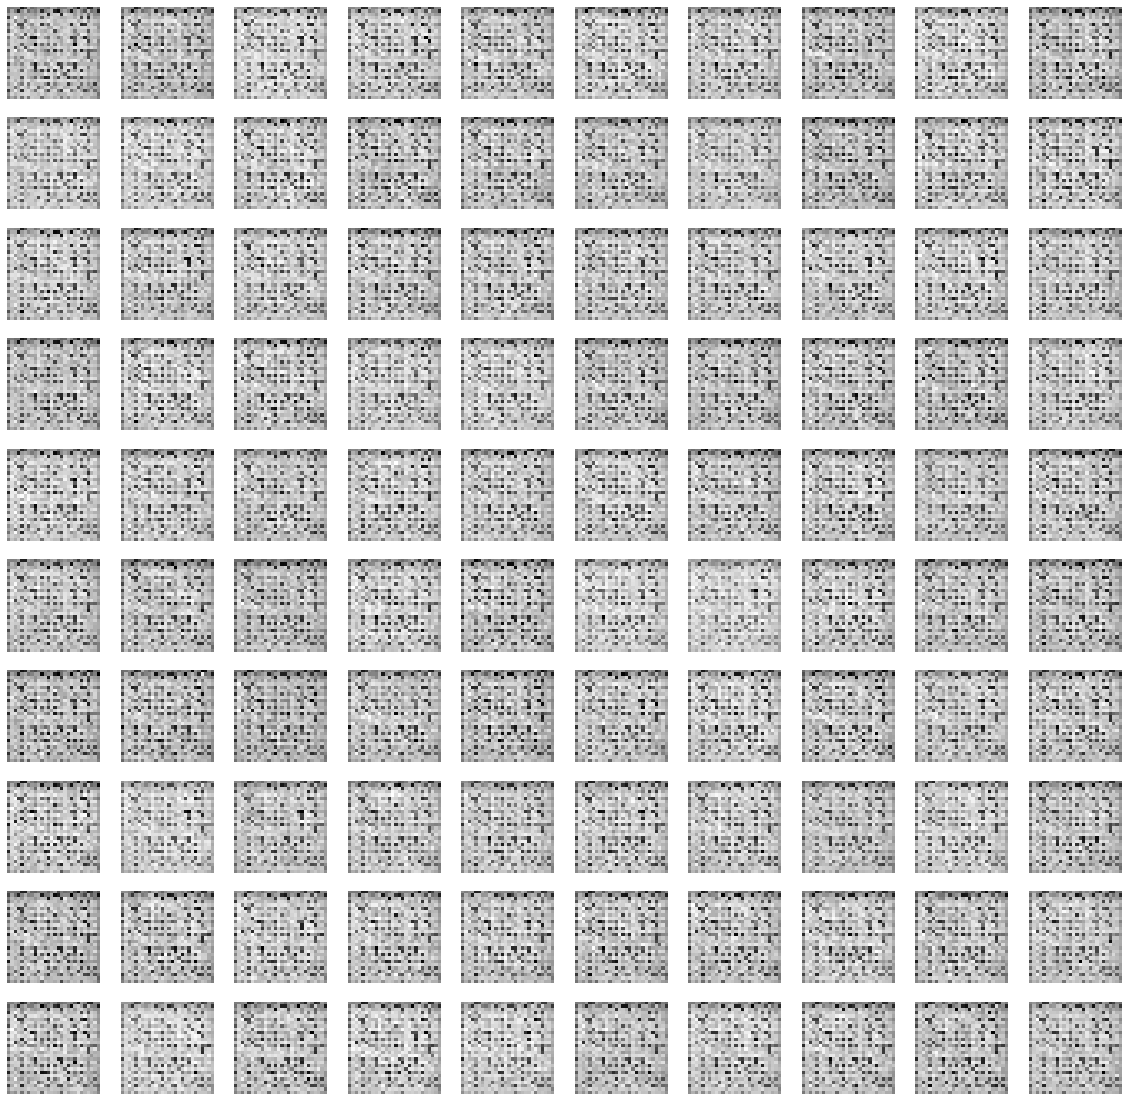

>136, d=0.002, g=0.539, a=100
>137, d=0.003, g=0.543, a=100
>138, d=0.002, g=0.547, a=100
>139, d=0.002, g=0.552, a=100
>140, d=0.002, g=0.556, a=100
>141, d=0.002, g=0.560, a=100
>142, d=0.001, g=0.565, a=100
>143, d=0.002, g=0.570, a=100
>144, d=0.002, g=0.575, a=100
>145, d=0.002, g=0.580, a=100
>146, d=0.001, g=0.586, a=100
>147, d=0.002, g=0.591, a=100
>148, d=0.002, g=0.596, a=100
>149, d=0.001, g=0.601, a=100
>150, d=0.002, g=0.606, a=100
>151, d=0.001, g=0.612, a=100
>152, d=0.002, g=0.617, a=100
>153, d=0.002, g=0.623, a=100
>154, d=0.002, g=0.629, a=100
>155, d=0.001, g=0.635, a=100
>156, d=0.001, g=0.640, a=100
>157, d=0.001, g=0.646, a=100
>158, d=0.002, g=0.652, a=100
>159, d=0.002, g=0.657, a=100
>160, d=0.002, g=0.664, a=100
>161, d=0.002, g=0.671, a=100
>162, d=0.002, g=0.679, a=100
>163, d=0.001, g=0.684, a=100
>164, d=0.002, g=0.691, a=100
>165, d=0.001, g=0.698, a=100
>166, d=0.001, g=0.704, a=100
>167, d=0.001, g=0.711, a=100
>168, d=0.001, g=0.719, a=100
>169, d=0.

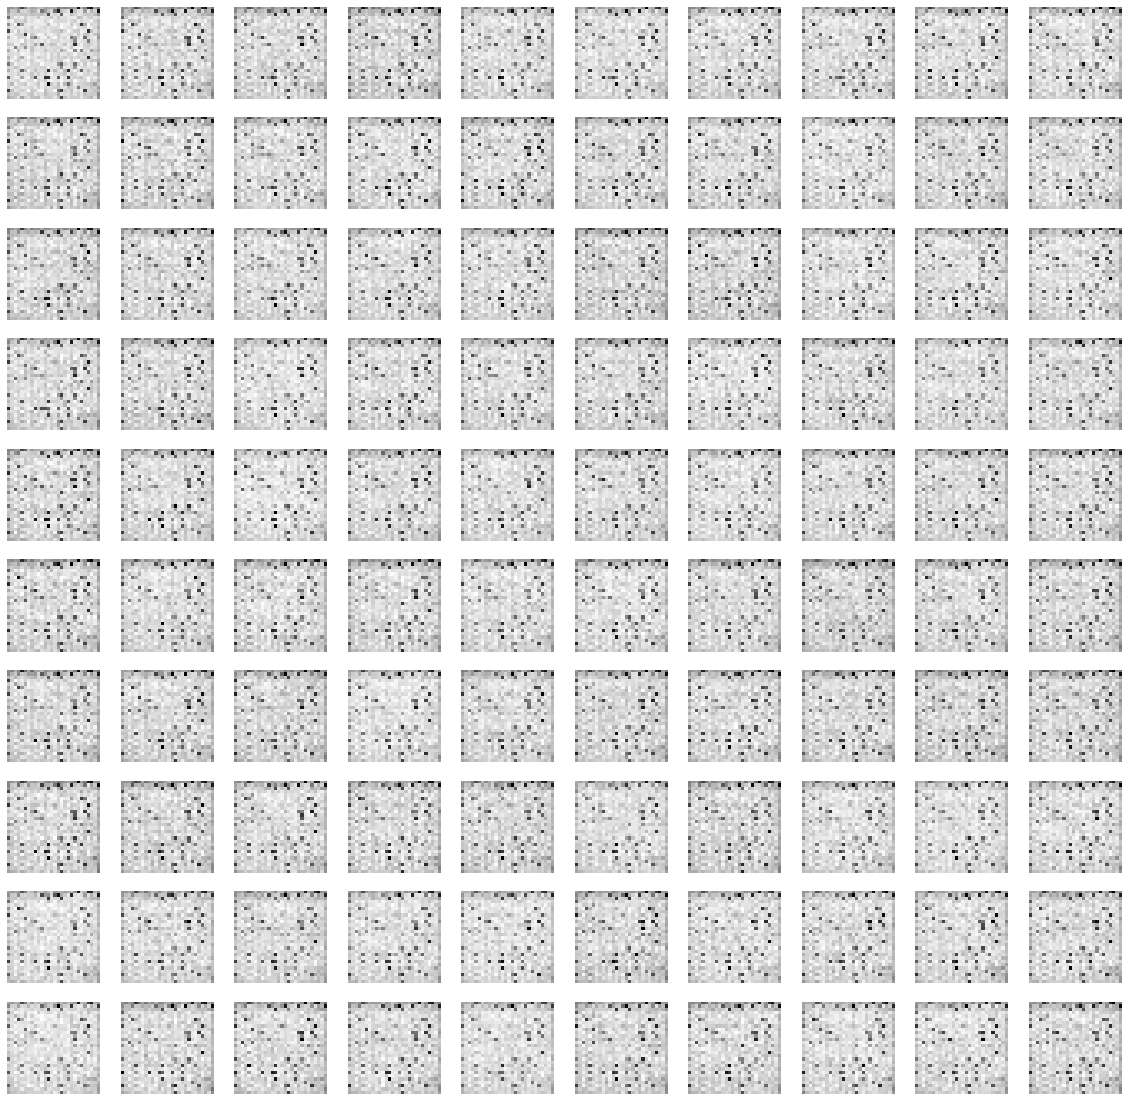

>181, d=0.004, g=0.859, a=100
>182, d=0.004, g=0.877, a=100
>183, d=0.004, g=0.897, a=100
>184, d=0.004, g=0.918, a=100
>185, d=0.003, g=0.938, a=100
>186, d=0.002, g=0.956, a=100
>187, d=0.003, g=0.975, a=100
>188, d=0.002, g=0.993, a=100
>189, d=0.002, g=1.011, a=100
>190, d=0.002, g=1.029, a=100
>191, d=0.002, g=1.050, a=100
>192, d=0.002, g=1.069, a=100
>193, d=0.002, g=1.088, a=100
>194, d=0.002, g=1.110, a=100
>195, d=0.001, g=1.131, a=100
>196, d=0.001, g=1.152, a=100
>197, d=0.001, g=1.173, a=100
>198, d=0.001, g=1.195, a=100
>199, d=0.001, g=1.217, a=100
>200, d=0.001, g=1.237, a=100
>201, d=0.001, g=1.259, a=100
>202, d=0.001, g=1.281, a=100
>203, d=0.001, g=1.303, a=100
>204, d=0.001, g=1.324, a=100
>205, d=0.001, g=1.348, a=100
>206, d=0.002, g=1.368, a=100
>207, d=0.001, g=1.389, a=100
>208, d=0.001, g=1.412, a=100
>209, d=0.001, g=1.438, a=100
>210, d=0.001, g=1.463, a=100
>211, d=0.001, g=1.487, a=100
>212, d=0.002, g=1.512, a=100
>213, d=0.001, g=1.539, a=100
>214, d=0.

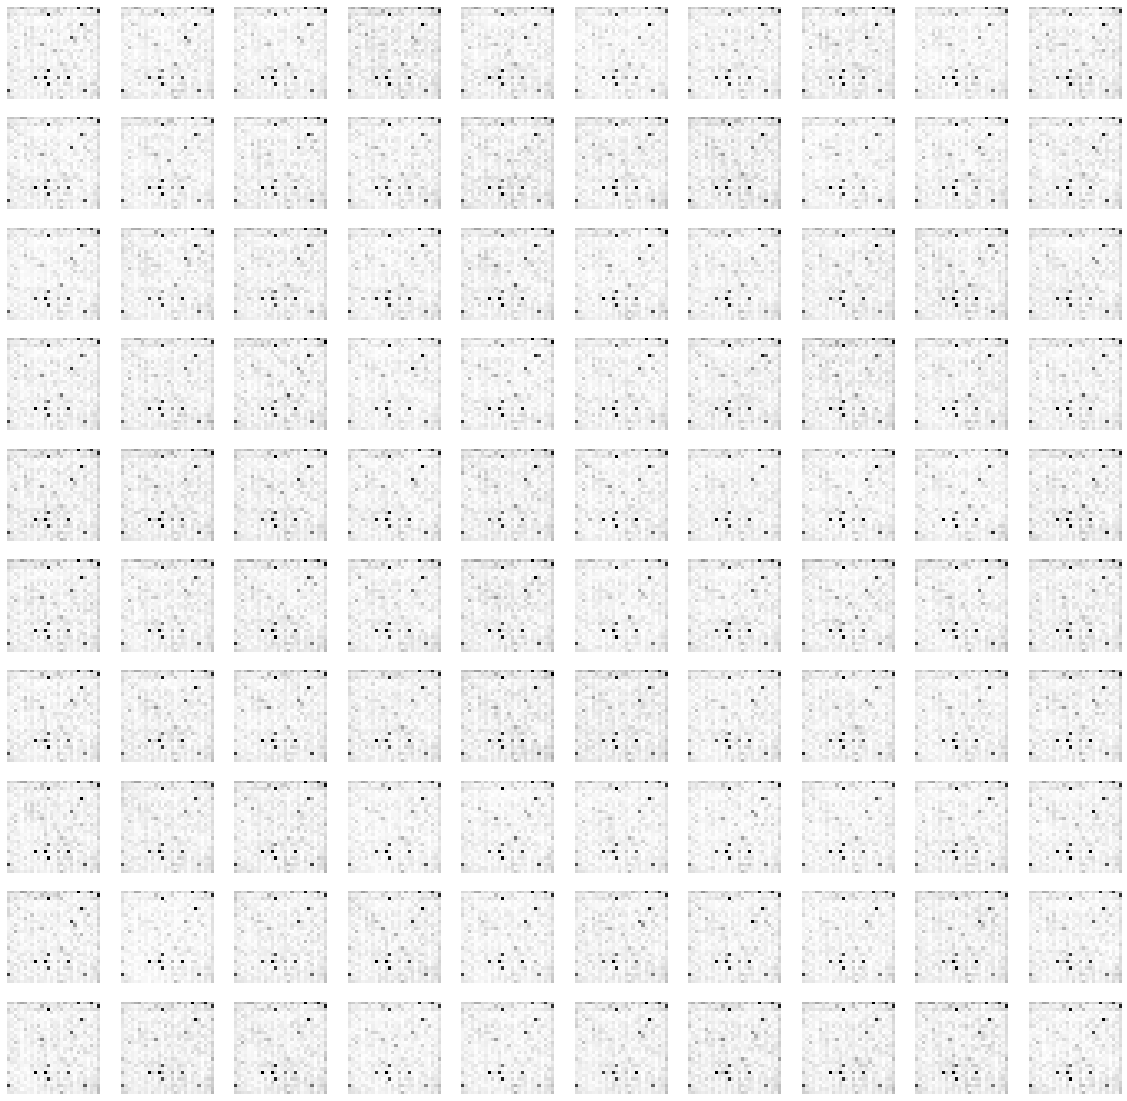

>226, d=0.002, g=1.941, a=100
>227, d=0.002, g=1.977, a=100
>228, d=0.002, g=2.018, a=100
>229, d=0.003, g=2.044, a=100
>230, d=0.002, g=2.083, a=100
>231, d=0.004, g=2.110, a=100
>232, d=0.003, g=2.150, a=100
>233, d=0.003, g=2.207, a=100
>234, d=0.002, g=2.270, a=100
>235, d=0.002, g=2.330, a=100
>236, d=0.002, g=2.392, a=100
>237, d=0.003, g=2.449, a=100
>238, d=0.002, g=2.497, a=100
>239, d=0.002, g=2.540, a=100
>240, d=0.002, g=2.587, a=100
>241, d=0.002, g=2.632, a=100
>242, d=0.002, g=2.680, a=100
>243, d=0.002, g=2.727, a=100
>244, d=0.003, g=2.774, a=100
>245, d=0.009, g=2.789, a=99
>246, d=0.003, g=2.819, a=100
>247, d=0.005, g=2.886, a=100
>248, d=0.003, g=2.978, a=100
>249, d=0.003, g=3.071, a=100
>250, d=0.003, g=3.155, a=100
>251, d=0.004, g=3.227, a=100
>252, d=0.003, g=3.300, a=100
>253, d=0.003, g=3.373, a=100
>254, d=0.008, g=3.453, a=100
>255, d=0.003, g=3.529, a=100
>256, d=0.002, g=3.604, a=100
>257, d=0.003, g=3.680, a=100
>258, d=0.003, g=3.751, a=100
>259, d=0.0

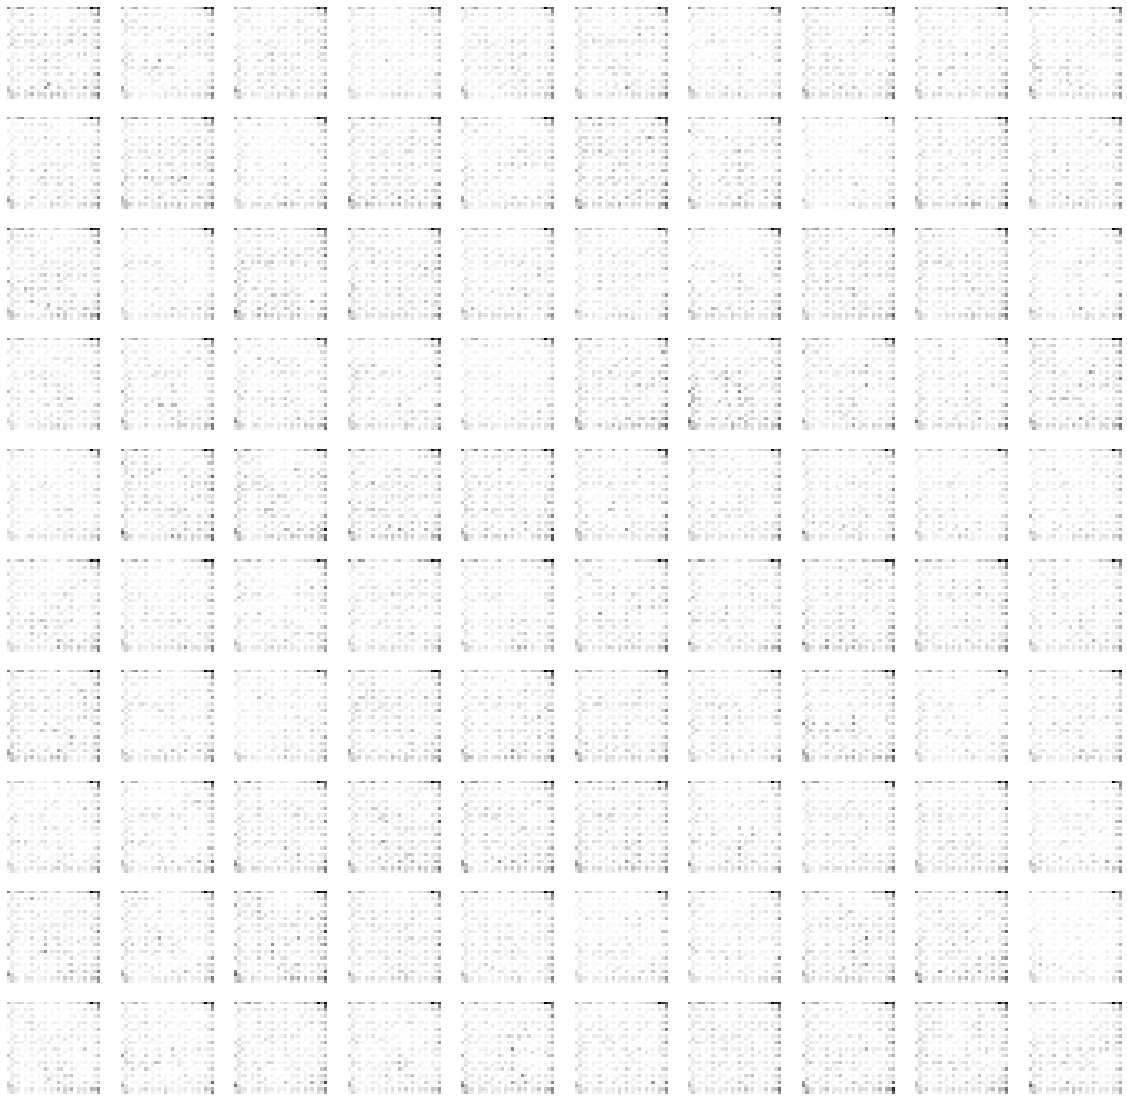

>271, d=0.002, g=4.659, a=100
>272, d=0.003, g=4.729, a=100
>273, d=0.003, g=4.799, a=100
>274, d=0.003, g=4.868, a=100
>275, d=0.004, g=4.935, a=100
>276, d=0.002, g=5.005, a=100
>277, d=0.003, g=5.071, a=100
>278, d=0.003, g=5.136, a=100
>279, d=0.002, g=5.203, a=100
>280, d=0.002, g=5.269, a=100
>281, d=0.002, g=5.336, a=100
>282, d=0.002, g=5.402, a=100
>283, d=0.003, g=5.464, a=100
>284, d=0.002, g=5.523, a=100
>285, d=0.003, g=5.580, a=100
>286, d=0.003, g=5.634, a=100
>287, d=0.002, g=5.689, a=100
>288, d=0.001, g=5.745, a=100
>289, d=0.002, g=5.795, a=100
>290, d=0.001, g=5.851, a=100
>291, d=0.001, g=5.904, a=100
>292, d=0.002, g=5.954, a=100
>293, d=0.001, g=6.003, a=100
>294, d=0.003, g=6.054, a=100
>295, d=0.001, g=6.104, a=100
>296, d=0.002, g=6.151, a=100
>297, d=0.001, g=6.200, a=100
>298, d=0.001, g=6.247, a=100
>299, d=0.002, g=6.294, a=100
>300, d=0.007, g=6.348, a=100
>301, d=0.001, g=6.398, a=100
>302, d=0.001, g=6.444, a=100
>303, d=0.001, g=6.491, a=100
>304, d=0.

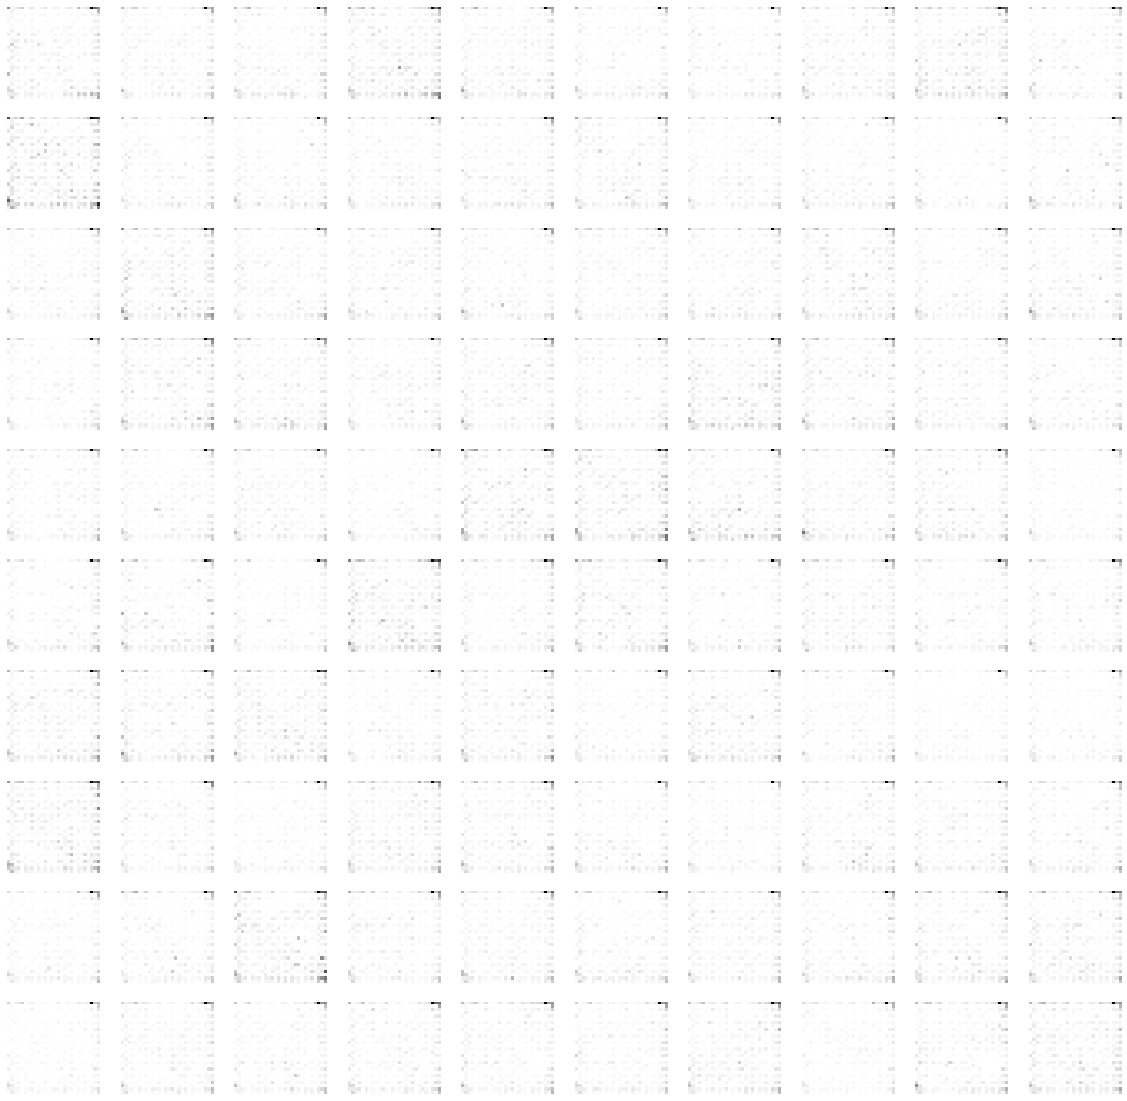

>316, d=0.001, g=7.006, a=100
>317, d=0.001, g=7.043, a=100
>318, d=0.001, g=7.081, a=100
>319, d=0.001, g=7.118, a=100
>320, d=0.001, g=7.154, a=100
>321, d=0.001, g=7.189, a=100
>322, d=0.001, g=7.223, a=100
>323, d=0.001, g=7.256, a=100
>324, d=0.001, g=7.289, a=100
>325, d=0.001, g=7.321, a=100
>326, d=0.001, g=7.354, a=100
>327, d=0.001, g=7.388, a=100
>328, d=0.001, g=7.412, a=100
>329, d=0.001, g=7.440, a=100
>330, d=0.001, g=7.467, a=100
>331, d=0.001, g=7.496, a=100
>332, d=0.001, g=7.527, a=100
>333, d=0.001, g=7.556, a=100
>334, d=0.000, g=7.586, a=100
>335, d=0.001, g=7.617, a=100
>336, d=0.001, g=7.646, a=100
>337, d=0.001, g=7.675, a=100
>338, d=0.000, g=7.704, a=100
>339, d=0.001, g=7.734, a=100
>340, d=0.001, g=7.760, a=100
>341, d=0.001, g=7.780, a=100
>342, d=0.001, g=7.804, a=100
>343, d=0.001, g=7.829, a=100
>344, d=0.001, g=7.856, a=100
>345, d=0.000, g=7.883, a=100
>346, d=0.001, g=7.909, a=100
>347, d=0.001, g=7.931, a=100
>348, d=0.001, g=7.950, a=100
>349, d=0.

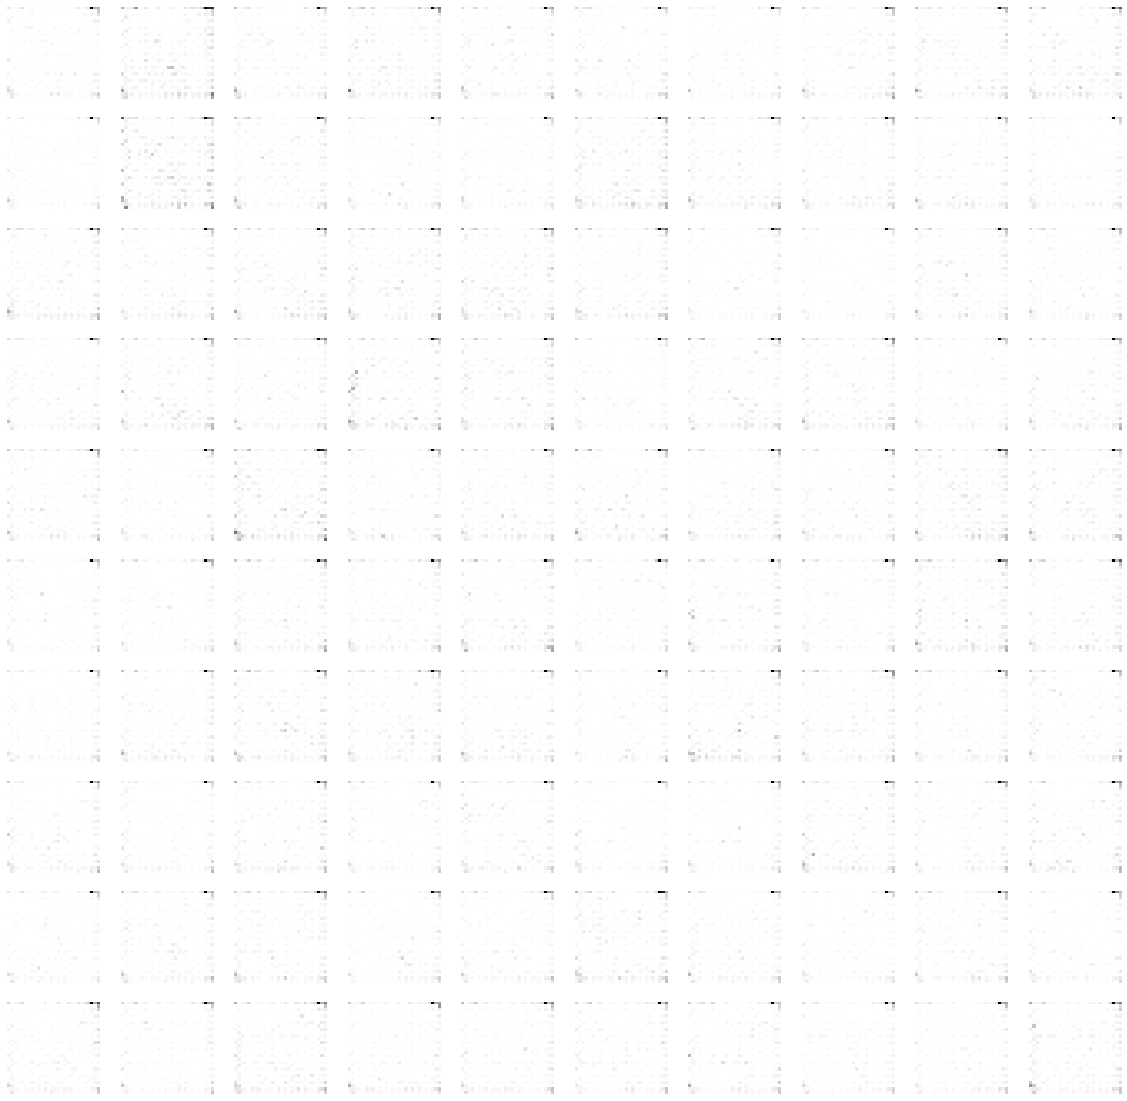

>361, d=0.001, g=8.230, a=100
>362, d=0.001, g=8.256, a=100
>363, d=0.001, g=8.284, a=100
>364, d=0.001, g=8.312, a=100
>365, d=0.001, g=8.341, a=100
>366, d=0.001, g=8.369, a=100
>367, d=0.001, g=8.397, a=100
>368, d=0.001, g=8.420, a=100
>369, d=0.001, g=8.441, a=100
>370, d=0.001, g=8.460, a=100
>371, d=0.001, g=8.481, a=100
>372, d=0.000, g=8.503, a=100
>373, d=0.001, g=8.526, a=100
>374, d=0.001, g=8.546, a=100
>375, d=0.001, g=8.566, a=100
>376, d=0.001, g=8.582, a=100
>377, d=0.000, g=8.602, a=100
>378, d=0.001, g=8.622, a=100
>379, d=0.004, g=8.634, a=100
>380, d=0.001, g=8.649, a=100
>381, d=0.001, g=8.667, a=100
>382, d=0.001, g=8.688, a=100
>383, d=0.001, g=8.708, a=100
>384, d=0.001, g=8.729, a=100
>385, d=0.001, g=8.746, a=100
>386, d=0.001, g=8.766, a=100
>387, d=0.001, g=8.782, a=100
>388, d=0.001, g=8.798, a=100
>389, d=0.001, g=8.814, a=100
>390, d=0.001, g=8.826, a=100
>391, d=0.001, g=8.842, a=100
>392, d=0.001, g=8.855, a=100
>393, d=0.001, g=8.872, a=100
>394, d=0.

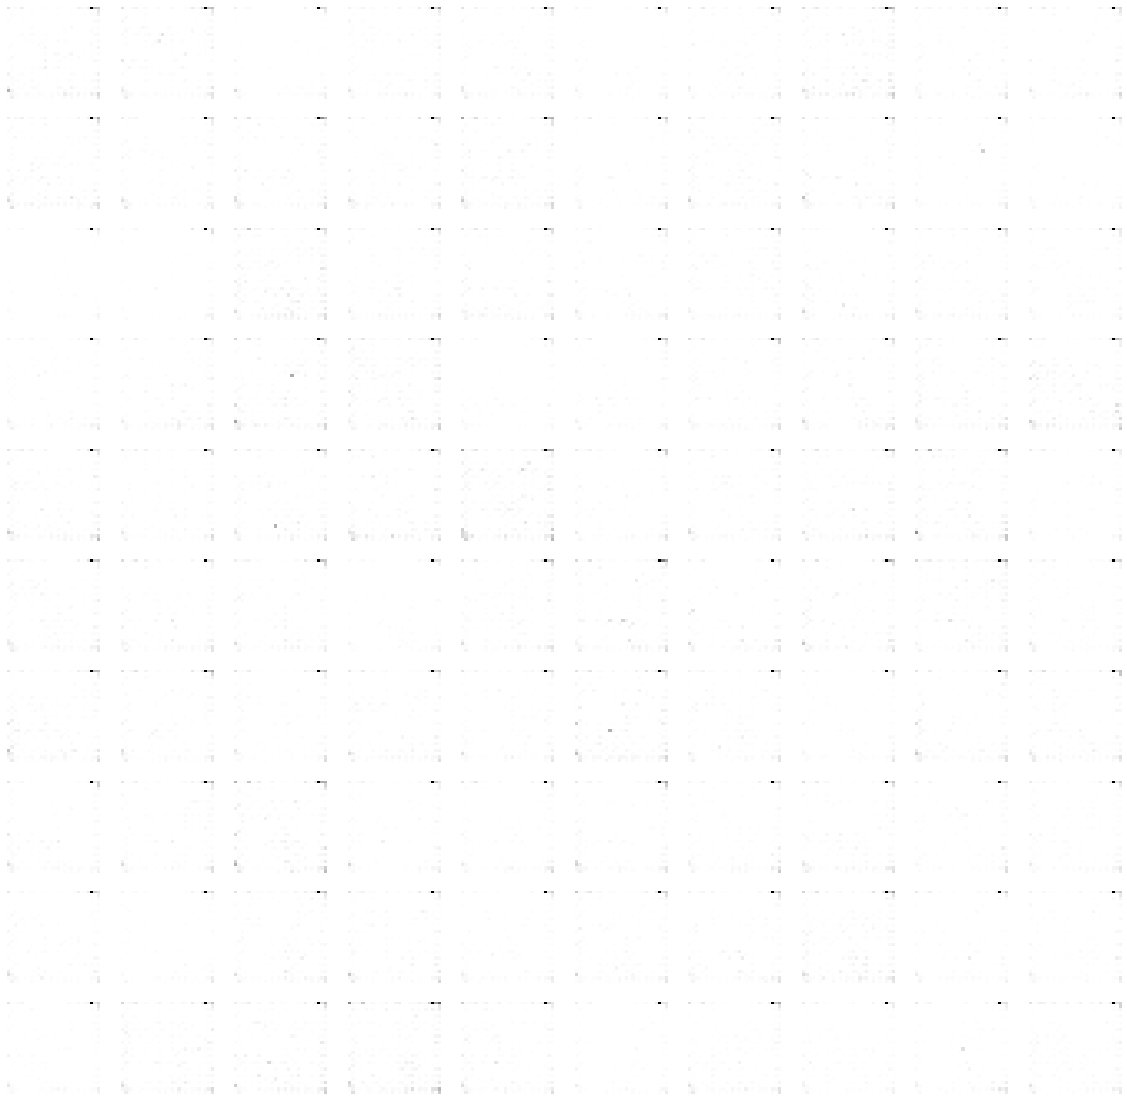

>406, d=0.000, g=9.000, a=100
>407, d=0.000, g=9.013, a=100
>408, d=0.001, g=9.026, a=100
>409, d=0.001, g=9.038, a=100
>410, d=0.000, g=9.051, a=100
>411, d=0.000, g=9.066, a=100
>412, d=0.000, g=9.080, a=100
>413, d=0.000, g=9.093, a=100
>414, d=0.000, g=9.107, a=100
>415, d=0.001, g=9.120, a=100
>416, d=0.000, g=9.133, a=100
>417, d=0.001, g=9.147, a=100
>418, d=0.000, g=9.157, a=100
>419, d=0.000, g=9.170, a=100
>420, d=0.000, g=9.182, a=100
>421, d=0.001, g=9.185, a=100
>422, d=0.000, g=9.192, a=100
>423, d=0.000, g=9.202, a=100
>424, d=0.000, g=9.213, a=100
>425, d=0.000, g=9.223, a=100
>426, d=0.001, g=9.227, a=100
>427, d=0.000, g=9.234, a=100
>428, d=0.000, g=9.242, a=100
>429, d=0.000, g=9.250, a=100
>430, d=0.001, g=9.254, a=100
>431, d=0.001, g=9.259, a=100
>432, d=0.000, g=9.268, a=100
>433, d=0.000, g=9.278, a=100
>434, d=0.001, g=9.284, a=100
>435, d=0.000, g=9.292, a=100
>436, d=0.001, g=9.292, a=100
>437, d=0.000, g=9.298, a=100
>438, d=0.001, g=9.301, a=100
>439, d=0.

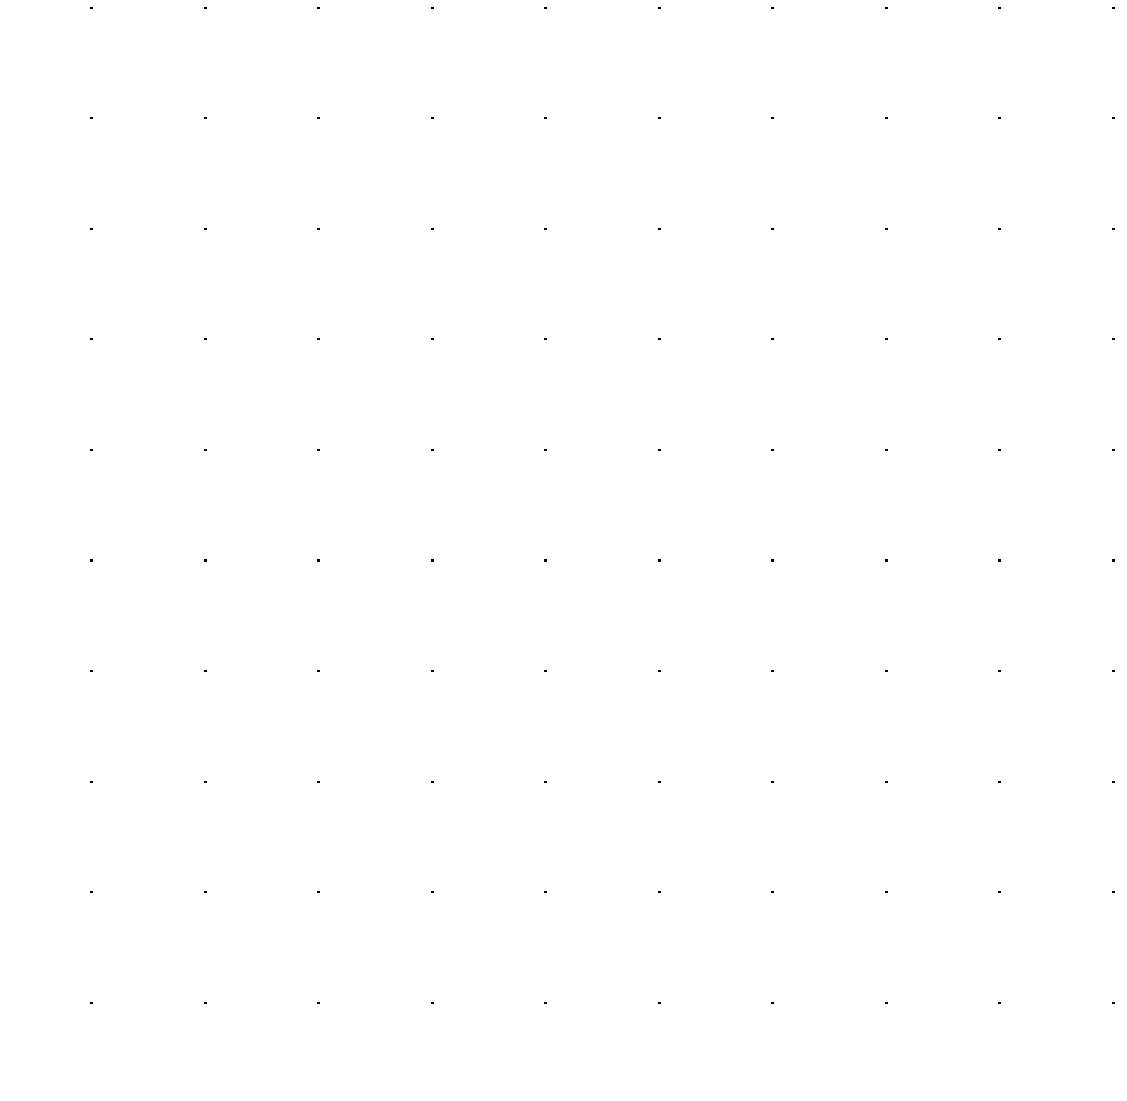

NameError: name 'd1_hist' is not defined

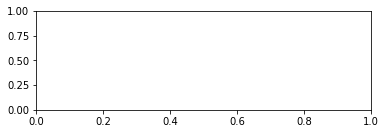

In [14]:
# make folder for results 
makedirs('results_baseline', exist_ok=True)
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
print(dataset.shape)
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)